In [2]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=669666d8871e3016a059d78fa5c177fe8b214d0a5a653a50c0210d8982f78eb3
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [4]:
import os
import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

import imgaug.augmenters as iaa

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from sklearn.decomposition import PCA

from deepface import DeepFace

2025-04-30 10:37:33.830255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746009454.082455      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746009454.156041      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-04-30 10:37:48 - Directory /root/.deepface has been created
25-04-30 10:37:48 - Directory /root/.deepface/weights has been created


In [4]:
import os
import pandas as pd

# Define the base directory where images are stored
base_dir = "/kaggle/input/faces-data-for-recognise-me/lfw_faces data+me"

# List all image files recursively
image_paths = []
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")

Found 13244 images.


In [5]:
# Extract person names from filenames
persons = []
for path in image_paths:
    filename = os.path.basename(path)  # e.g., "Aaron_Eckhart_0001.jpg"
    person_name = "_".join(filename.split("_")[:-1])  # Removes "_0001.jpg"
    persons.append(person_name)

In [6]:
# Create a DataFrame
df = pd.DataFrame({
    "person": persons,
    "path": image_paths
})

# Display the first 5 rows
df.head()

,person,path
0,Riek_Blanjaar,/kaggle/input/faces-data-for-recognise-me/lfw_...
1,Jennifer_Garner,/kaggle/input/faces-data-for-recognise-me/lfw_...
2,Robert_McKee,/kaggle/input/faces-data-for-recognise-me/lfw_...
3,Antonio_Banderas,/kaggle/input/faces-data-for-recognise-me/lfw_...
4,Sarah_Canale,/kaggle/input/faces-data-for-recognise-me/lfw_...


In [7]:
print('size of data:',df.shape)
print('-------------------------------------------------------')
image_counts = df["person"].value_counts()
count_people_has_1_imgs = (image_counts == 1).sum()
print('count of people that has 1 imgs:',count_people_has_1_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_10_imgs = (image_counts >= 10).sum()
print('count of people that has more than or equal 10 imgs:',count_people_has_more_than_10_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_1_imgs = (image_counts > 1).sum()
print('count of people that has more than 1 imgs:',count_people_has_more_than_1_imgs)

size of data: (13244, 2)
-------------------------------------------------------
count of people that has 1 imgs: 4069
-------------------------------------------------------
count of people that has more than or equal 10 imgs: 159
-------------------------------------------------------
count of people that has more than 1 imgs: 1681


In [8]:
df_show = []
columns = df. columns 
for i in columns : 
    types = df[i] . dtypes
    
    unique_data = df[i] . nunique()
                   
    NAN_value=df[i].isnull().sum() 
        
    duplicated= df.duplicated().sum()    
    df_show . append ([i , types , unique_data , NAN_value,duplicated])
        
df_info = pd . DataFrame (df_show)
df_info . columns =['Columns' , 'Types' ,'Unique_Data' , 'NAN value',"Duplicated"]




df_info.style.highlight_max(color = 'pink', axis = 0)

,Columns,Types,Unique_Data,NAN value,Duplicated
0,person,object,5750,0,0
1,path,object,13244,0,0


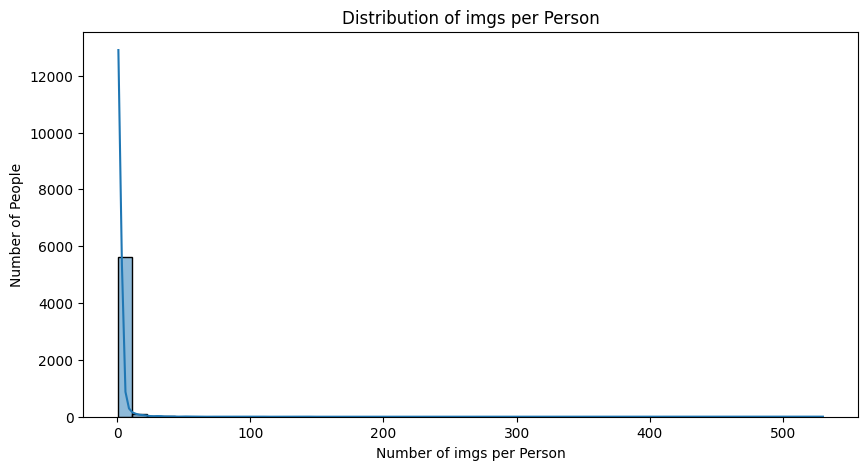

In [9]:
image_counts = df["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution of imgs per Person")
plt.show()

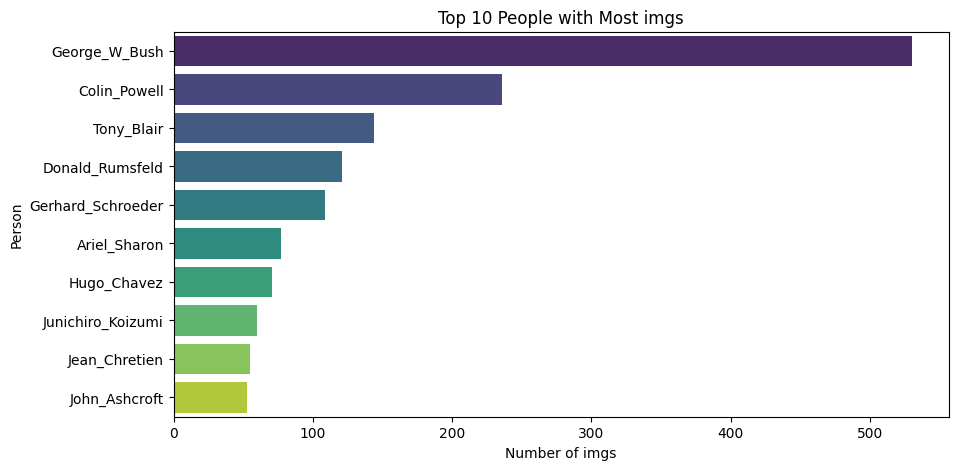

In [10]:
top_10_people = image_counts.head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_people.values, y=top_10_people.index, palette="viridis")
plt.xlabel("Number of imgs")
plt.ylabel("Person")
plt.title("Top 10 People with Most imgs")
plt.show()

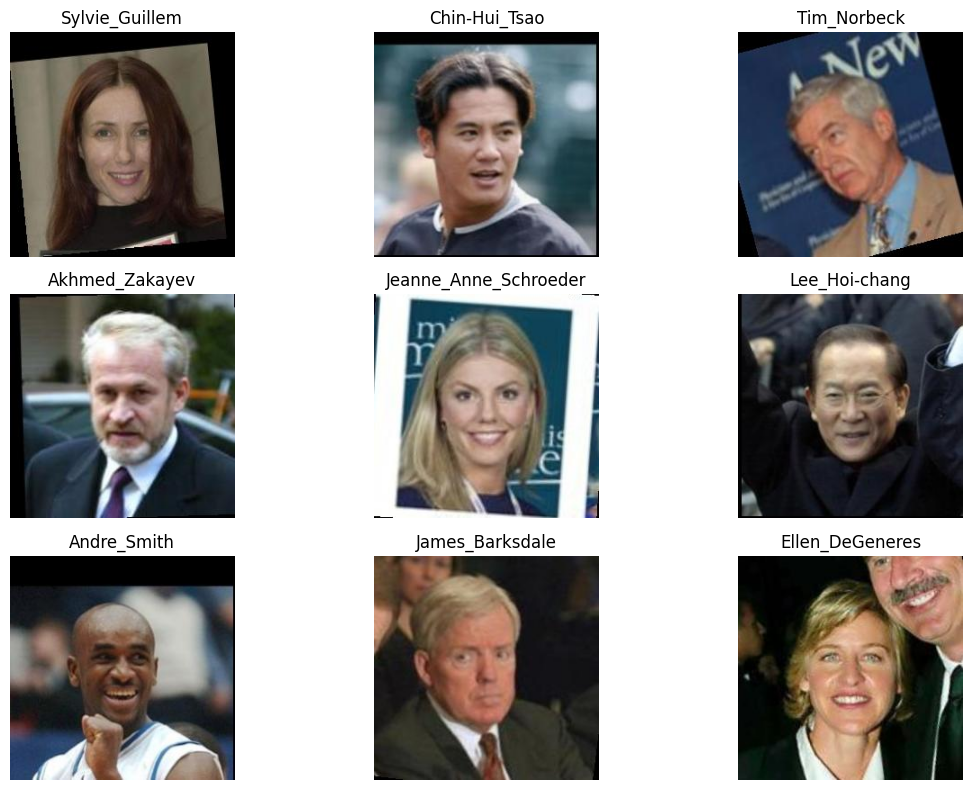

In [11]:
def plot_sample_imgs(dataset, num_samples=9):
    sample_people = random.sample(list(dataset["person"].unique()), num_samples)
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    for ax, person in zip(axes.flat, sample_people):
        person_images = dataset[dataset["person"] == person]["path"].values
        img_path = random.choice(person_images)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(img)
        ax.set_title(person)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_imgs(df)

In [12]:
# remove people with fewer than 5 images
filtered_dataset = df.groupby("person").filter(lambda x: len(x) >= 10)

# limit each person to max 30 images
def limit_images(group):
    return group.sample(n=min(len(group), 30), random_state=42)

df = filtered_dataset.groupby("person").apply(limit_images).reset_index(drop=True)

print("Dataset size after filtering:", df.shape)

Dataset size after filtering: (2985, 2)


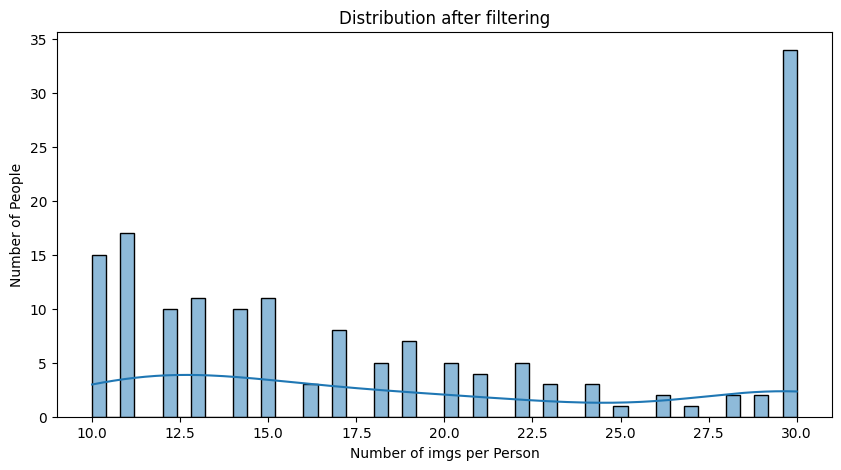

In [13]:
image_counts = df["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution after filtering")
plt.show()

In [14]:
print('size of data:',df.shape)
print('-------------------------------------------------------')
image_counts = df["person"].value_counts()
count_people_after_filtering = (image_counts > 1).sum()
print('count of people after filtering:',count_people_after_filtering)

size of data: (2985, 2)
-------------------------------------------------------
count of people after filtering: 159


In [17]:
from imgaug import augmenters as iaa
import cv2
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os

# Define augmentation pipeline
augmenter = iaa.Sequential([
    # 1. Horizontal Flip (50% chance)
    iaa.Fliplr(0.5),  
    
    # 2. Rotation (±20 degrees) + Zoom (Optional)
    iaa.Affine(
        rotate=(-20, 20),  
        scale=(0.9, 1.1),  # Mild zoom (10% in/out) - REMOVE if unwanted
    ),  
    
    # 3. Brightness Adjustment (80-120%)
    iaa.Multiply((0.8, 1.2)),  
    
    # 4. Mild Blur (sigma 0 to 1.0)
    iaa.GaussianBlur(sigma=(0, 1.0))  
])
# Create lists for new (augmented) data
augmented_data = {
    "person": [],
    "path": [],
    "image": []
}

# Loop through each image and apply augmentation
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row["path"])
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply augmentation
    aug_img = augmenter(image=img)

    # Save the augmented image and person label
    augmented_data["person"].append(row["person"])
    augmented_data["path"].append("augmented")  # placeholder
    augmented_data["image"].append(aug_img)

# Create DataFrame for augmented data
aug_df = pd.DataFrame({
    "person": augmented_data["person"],
    "path": augmented_data["path"],
    "image": augmented_data["image"]
})

# Add original image array column for training
df["image"] = df["path"].apply(lambda p: cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))

# Merge original and augmented data
final_df = pd.concat([df, aug_df], ignore_index=True)

print(f"Final dataset contains {len(final_df)} images.")


  0%|          | 0/2985 [00:00<?, ?it/s]

Final dataset contains 5970 images.


In [18]:
final_df.head()

,person,path,image
0,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[4, 0, 0], [3, 1, 0], [0, 1, 0], [0, 1, 0], ..."
2,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[94, 52, 12], [92, 50, 10], [89, 47, 9], [86..."
4,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [20]:
def get_embedding_from_array(img_array):
    try:
        embedding = DeepFace.represent(
            img_path=img_array,        # Pass image array instead of path
            model_name="VGG-Face",
            enforce_detection=False
        )[0]["embedding"]
        return embedding
    except Exception as e:
        print(f"Error extracting embedding: {e}")
        return None

In [21]:
final_df["embedding"] = final_df["image"].apply(get_embedding_from_array)

I0000 00:00:1745937219.746458      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


25-04-29 14:33:40 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:19<00:00, 30.3MB/s] 
I0000 00:00:1745937243.018975      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [22]:
print(final_df.size)

23880


In [23]:
final_df.head()

,person,path,image,embedding
0,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[4, 0, 0], [3, 1, 0], [0, 1, 0], [0, 1, 0], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[94, 52, 12], [92, 50, 10], [89, 47, 9], [86...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Abdullah_Gul,/kaggle/input/faces-data-for-recognise-me/lfw_...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
final_df = final_df.dropna(subset=["embedding"]).reset_index(drop=True)

In [25]:
label_mapping = {name: idx for idx, name in enumerate(final_df["person"].unique())}
final_df["label"] = final_df["person"].map(label_mapping)

In [ ]:
embeddings = final_df["embedding"].tolist()

In [ ]:
labels = final_df["label"].tolist()

assert len(embeddings) == len(labels), "Mismatch between embeddings and labels!"

In [28]:
final_df.shape

(5970, 5)

In [ ]:
X = np.array(embeddings)
y = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize SVM with the specific parameters
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True)

# Train the model
svm.fit(X_train, y_train)

# Predict using the model
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 93.30%


In [43]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       1.00      1.00      1.00         6
           2       0.67      0.86      0.75         7
           3       1.00      0.88      0.93         8
           4       0.60      1.00      0.75         9
           5       1.00      0.93      0.96        14
           6       1.00      0.93      0.97        15
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         1
          10       0.31      1.00      0.47         4
          11       1.00      0.75      0.86         4
          12       1.00      0.93      0.97        15
          13       0.83      0.91      0.87        11
          14       1.00      1.00      1.00         9
          15       1.00      0.82      0.90        11
          16       1.00      0.86      0.92         7
          17       1.00    